In [1]:
# !pip install xgboost
#!pip install scikit-learn

In [2]:
# !pip install shap

In this notebook, we focus on modeling for predicting customer churn. We begin by importing necessary libraries and then proceed with data preprocessing, feature engineering, and model training.

### Libraries
We import libraries required for data preprocessing, modeling, and evaluation.

### Preprocessing
We check and handle missing values, as well as identify and handle duplicated entries in the dataset.

### Feature Engineering
We calculate new features representing the growth of each existing feature over time.

### Checking Correlation
We analyze the correlation between features to identify potential relationships.

### Data Splitting
We split the data into training and test sets. The training data spans from January 2022 to September 2022, while the test data is from October 2022.

### Model Training
We train logistic regression and random forest models using cross-validation to refine the models and avoid overfitting.

### Model Comparison
We evaluate the models using F1 score and select the best performing model. 
After careful consideration, we've decided to go with the Random Forest model with cross-validation as our final choice. While Logistic Regression is a possible alternative, it requires dealing with multicollinearity issues and meetingother regressionnt assumption. Since this project primarily acts as a part of my portfolio, Id conclude the modeling process here.

### Backtesting
After selecting the final model, we backtest it using data  November 2022 to assess its performance on unseen data.


In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import os
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from config import credential_datamart, project_id_bq, churn_bq_db, churn_feature_table 
from module.utils import memory_usage, read_file, binary_label_summary
from module.viz_utils import metric_for_train_df, metric_for_test_df, conf_matrix_viz, shap_viz, correlation_plot, feature_importance_plot

In [3]:
credentials = service_account.Credentials.from_service_account_file(
    credential_datamart, scopes = ["https://www.googleapis.com/auth/cloud-platform"],
)
bq_client = bigquery.Client(project = project_id_bq, credentials = credentials)

In [4]:
# fetch data
query = """
SELECT  *
FROM
 `{project_id_bq}.{churn_bq_db}.{churn_feature_table}`
WHERE date between "2022-01-01" and "2022-11-30"
""".format(project_id_bq = project_id_bq, churn_bq_db = churn_bq_db, churn_feature_table = churn_feature_table)

df = bq_client.query(query).to_dataframe()



In [5]:
read_file(df)

SHAPE (3467, 41)
MISSING VALUES
                            column total_row_missing missing_value_rate
0               SUM_GMV_last30days               499             14.39%
1            SUM_GMV_last30_60days               710             20.48%
2            SUM_GMV_last60_90days               855             24.66%
3             SUM_PROMO_last30days               499             14.39%
4          SUM_PROMO_last30_60days               710             20.48%
5          SUM_PROMO_last60_90days               855             24.66%
6      SUM_PRDTRX_PROMO_last30days               506             14.59%
7   SUM_PRDTRX_PROMO_last30_60days               729             21.03%
8   SUM_PRDTRX_PROMO_last60_90days               881             25.41%
9           PROMO_ratio_last30days               499             14.39%
10       PROMO_ratio_last30_60days               710             20.48%
11       PROMO_ratio_last60_90days               855             24.66%
12              SUM_TRX_last30da

In [6]:
memory_usage()

,Size
__builtins__,9.09KB
datetime,416.00B
__file__,219.00B
timer,136.00B
binary_label_summary,136.00B
memory_usage,136.00B
obj_size_fmt,136.00B
read_file,136.00B
__cached__,129.00B
gc,72.00B


# Preprocessing

In [7]:
# check duplication
df[df.duplicated(subset=['customer_id','date'])]

,date,customer_id,week_date,SUM_GMV_last30days,SUM_GMV_last30_60days,SUM_GMV_last60_90days,SUM_PROMO_last30days,SUM_PROMO_last30_60days,SUM_PROMO_last60_90days,SUM_PRDTRX_PROMO_last30days,...,SUM_UNIQ_PROD_last90,SUM_CNCL_TRX_last90,GMV_to_TRX_30,GMV_to_TRX_60,GMV_to_TRX_90,AVG_GMV_MONTHLY,AVG_PROMO_MONTHLY,AVG_UNIQ_PROD_MONTHLY,AVG_CNCL_TRX_MONTHLY,is_churned


In [8]:
# categorize columns into numerical and categorical 
col_target = 'is_churned'
col_list = list(df.drop(col_target,axis=1).columns)
col_numerical = list(df[col_list].select_dtypes(include=np.number).columns)
col_categorical = list(df[col_list].select_dtypes(include=object).columns)
print('NUMERICAL:',len(col_numerical),'out of',len(col_list), 'columns')
[ print(i) for i in col_numerical]
print('=========================')
print('CATEGORICAL:',len(col_categorical),'out of',len(col_list), 'columns')
for i in col_categorical:
    print(i)

NUMERICAL: 37 out of 40 columns
SUM_GMV_last30days
SUM_GMV_last30_60days
SUM_GMV_last60_90days
SUM_PROMO_last30days
SUM_PROMO_last30_60days
SUM_PROMO_last60_90days
SUM_PRDTRX_PROMO_last30days
SUM_PRDTRX_PROMO_last30_60days
SUM_PRDTRX_PROMO_last60_90days
SUM_PRDTRX_last30days
SUM_PRDTRX_last30_60days
SUM_PRDTRX_last60_90days
PROMO_ratio_last30days
PROMO_ratio_last30_60days
PROMO_ratio_last60_90days
SUM_PROMO_last90
SUM_GMV_last90
SUM_TRX_last30days
SUM_TRX_last30_60days
SUM_TRX_last60_90days
SUM_UNIQ_PROD_last30days
SUM_UNIQ_PROD_last30_60days
SUM_UNIQ_PROD_last60_90days
SUM_CNCL_TRX_last30days
SUM_CNCL_TRX_last30_60days
SUM_CNCL_TRX_last60_90days
n_month_active
SUM_TRX_last90
SUM_UNIQ_PROD_last90
SUM_CNCL_TRX_last90
GMV_to_TRX_30
GMV_to_TRX_60
GMV_to_TRX_90
AVG_GMV_MONTHLY
AVG_PROMO_MONTHLY
AVG_UNIQ_PROD_MONTHLY
AVG_CNCL_TRX_MONTHLY
CATEGORICAL: 1 out of 40 columns
customer_id


In [9]:
# missing values
# df.fillna(0,inplace=True)
df = df.replace(np.nan, 0)

In [10]:
# check negative values
for i in df.columns:
    if i not in col_categorical:
        print(i,min(df[i]))

date 2022-01-03
week_date 2022-01-03
SUM_GMV_last30days 0.0
SUM_GMV_last30_60days 0.0
SUM_GMV_last60_90days 0.0
SUM_PROMO_last30days 0.0
SUM_PROMO_last30_60days 0.0
SUM_PROMO_last60_90days 0.0
SUM_PRDTRX_PROMO_last30days 0
SUM_PRDTRX_PROMO_last30_60days 0
SUM_PRDTRX_PROMO_last60_90days 0
SUM_PRDTRX_last30days 0
SUM_PRDTRX_last30_60days 0
SUM_PRDTRX_last60_90days 0
PROMO_ratio_last30days 0.0
PROMO_ratio_last30_60days 0.0
PROMO_ratio_last60_90days 0.0
SUM_PROMO_last90 0.0
SUM_GMV_last90 0.0
SUM_TRX_last30days 0
SUM_TRX_last30_60days 0
SUM_TRX_last60_90days 0
SUM_UNIQ_PROD_last30days 0
SUM_UNIQ_PROD_last30_60days 0
SUM_UNIQ_PROD_last60_90days 0
SUM_CNCL_TRX_last30days 0
SUM_CNCL_TRX_last30_60days 0
SUM_CNCL_TRX_last60_90days 0
n_month_active 0
SUM_TRX_last90 0
SUM_UNIQ_PROD_last90 0
SUM_CNCL_TRX_last90 0
GMV_to_TRX_30 0.0
GMV_to_TRX_60 0.0
GMV_to_TRX_90 0.0
AVG_GMV_MONTHLY 0.0
AVG_PROMO_MONTHLY 0.0
AVG_UNIQ_PROD_MONTHLY 0.0
AVG_CNCL_TRX_MONTHLY 0.0
is_churned 0


# Feature Engineering

In [11]:
col_growth = ["SUM_GMV_last30days",
 "SUM_PROMO_last30days",
 "SUM_PRDTRX_PROMO_last30days",
 "SUM_PRDTRX_last30days",
 "SUM_TRX_last30days",
 "SUM_UNIQ_PROD_last30days",
 "SUM_CNCL_TRX_last30days"]

In [12]:
# calculate growth
for i in col_growth:
    df['{}_growth'.format(i[:-11])] = (df[i].div(df['{}_60days'.format(i[:-4])]).replace(np.inf, 0))

In [13]:
df.replace(np.nan, 0,inplace=True)

In [14]:
df.columns

Index(['date', 'customer_id', 'week_date', 'SUM_GMV_last30days',
       'SUM_GMV_last30_60days', 'SUM_GMV_last60_90days',
       'SUM_PROMO_last30days', 'SUM_PROMO_last30_60days',
       'SUM_PROMO_last60_90days', 'SUM_PRDTRX_PROMO_last30days',
       'SUM_PRDTRX_PROMO_last30_60days', 'SUM_PRDTRX_PROMO_last60_90days',
       'SUM_PRDTRX_last30days', 'SUM_PRDTRX_last30_60days',
       'SUM_PRDTRX_last60_90days', 'PROMO_ratio_last30days',
       'PROMO_ratio_last30_60days', 'PROMO_ratio_last60_90days',
       'SUM_PROMO_last90', 'SUM_GMV_last90', 'SUM_TRX_last30days',
       'SUM_TRX_last30_60days', 'SUM_TRX_last60_90days',
       'SUM_UNIQ_PROD_last30days', 'SUM_UNIQ_PROD_last30_60days',
       'SUM_UNIQ_PROD_last60_90days', 'SUM_CNCL_TRX_last30days',
       'SUM_CNCL_TRX_last30_60days', 'SUM_CNCL_TRX_last60_90days',
       'n_month_active', 'SUM_TRX_last90', 'SUM_UNIQ_PROD_last90',
       'SUM_CNCL_TRX_last90', 'GMV_to_TRX_30', 'GMV_to_TRX_60',
       'GMV_to_TRX_90', 'AVG_GMV_MONTHLY'

In [15]:
# categorize columns into numerical and categorical 
col_list = list(df.drop(col_target,axis=1).columns)
col_numerical = list(df[col_list].select_dtypes(include=np.number).columns)
col_categorical = list(df.drop(columns=['customer_id']).select_dtypes(include='object').columns)
print('NUMERICAL:',len(col_numerical),'out of',len(col_list), 'columns')
print('CATEGORICAL:',len(col_categorical),'out of',len(col_list), 'columns')

NUMERICAL: 44 out of 47 columns
CATEGORICAL: 0 out of 47 columns


<Axes: >

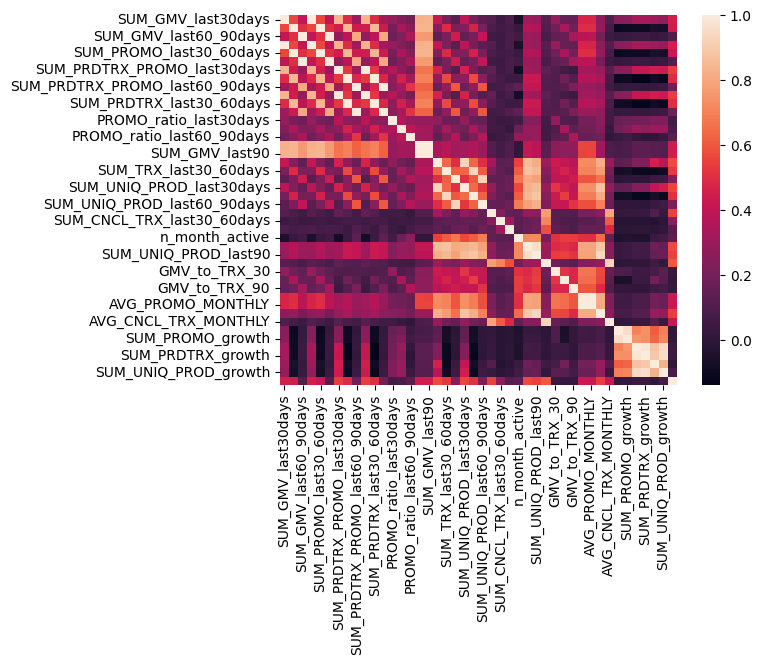

In [16]:
sns.heatmap(df[col_numerical].corr())

In [17]:
# # as there's a bug preventing the filling or replacement of null values, these functions serve as a workaround.
def convert_nan_to_zero(df):
    for column in df.columns:
        for index, value in df[column].items():
            if pd.isna(value):
                df.at[index, column] = 0
    return df

In [18]:
df=convert_nan_to_zero(df)

In [23]:
# split
# X_train = df.loc[df['date'] <  pd.to_datetime('2022-07-01')].drop(col_target,axis=1)
# y_train = df.loc[df['date'] <  pd.to_datetime('2022-07-01')][col_target]
X_train = df.loc[(df['date'] >=  pd.to_datetime('2022-01-01') )& (df['date'] <  pd.to_datetime('2022-10-01'))].drop(col_target,axis=1)
y_train = df.loc[(df['date'] >=  pd.to_datetime('2022-01-01') )& (df['date'] <  pd.to_datetime('2022-10-01'))][col_target]
X_test = df.loc[(df['date'] >=  pd.to_datetime('2022-10-01') )& (df['date'] <  pd.to_datetime('2022-11-01'))].drop(col_target,axis=1)
y_test = df.loc[(df['date'] >=  pd.to_datetime('2022-10-01') )& (df['date'] <  pd.to_datetime('2022-11-01'))][col_target]

In [24]:
X_train['type'] = 'TRAIN'
X_test['type'] = 'TEST'
list_file = [X_train,X_test]
df_combined = pd.concat(list_file,axis=0)
list_file = [y_train,y_test]
y_combined = pd.concat(list_file,axis=0)
df_combined[col_target] = y_combined
del y_combined


In [25]:
# label distribution
data_summary = df_combined.groupby(['type']).aggregate({col_target:['sum','count']})
data_summary.columns = [col_target, 'total_data']
data_summary[col_target+' rate'] = data_summary[col_target] / data_summary['total_data']
display(data_summary)

,is_churned,total_data,is_churned rate
type,,,
TEST,57,434,0.131336
TRAIN,375,2576,0.145575


In [26]:
del data_summary,df_combined

In [27]:
# ['SUM_GMV_last30days',
#  'SUM_GMV_last30_60days',
#  'SUM_GMV_last60_90days',
#  'SUM_PROMO_last30days',
#  'SUM_PROMO_last30_60days',
#  'SUM_PROMO_last60_90days',
#  'SUM_PRDTRX_PROMO_last30days',
#  'SUM_PRDTRX_PROMO_last30_60days',
#  'SUM_PRDTRX_PROMO_last60_90days',
#  'SUM_PRDTRX_last30days',
#  'SUM_PRDTRX_last30_60days',
#  'SUM_PRDTRX_last60_90days',
#  'PROMO_ratio_last30days',
#  'PROMO_ratio_last30_60days',
#  'PROMO_ratio_last60_90days',
#  'SUM_PROMO_last90',
#  'SUM_GMV_last90',
#  'SUM_TRX_last30days',
#  'SUM_TRX_last30_60days',
#  'SUM_TRX_last60_90days',
#  'SUM_UNIQ_PROD_last30days',
#  'SUM_UNIQ_PROD_last30_60days',
#  'SUM_UNIQ_PROD_last60_90days',
#  'SUM_CNCL_TRX_last30days',
#  'SUM_CNCL_TRX_last30_60days',
#  'SUM_CNCL_TRX_last60_90days',
#  'n_month_active',
#  'SUM_TRX_last90',
#  'SUM_UNIQ_PROD_last90',
#  'SUM_CNCL_TRX_last90',
#  'GMV_to_TRX_30',
#  'GMV_to_TRX_60',
#  'GMV_to_TRX_90',
#  'AVG_GMV_MONTHLY',
#  'AVG_PROMO_MONTHLY',
#  'AVG_UNIQ_PROD_MONTHLY',
#  'AVG_CNCL_TRX_MONTHLY',
#  'SUM_GMV_growth',
#  'SUM_PROMO_growth',
#  'SUM_PRDTRX_PROMO_growth',
#  'SUM_PRDTRX_growth',
#  'SUM_TRX_growth',
#  'SUM_UNIQ_PROD_growth',
#  'SUM_CNCL_TRX_growth']

In [28]:
# stored the standardscaler output on cols_sd
cols_sd = [i+'_sd' for i in col_numerical if i !='n_month_active']

In [29]:
# SCALER
min_max = MinMaxScaler()
X_train[cols_sd] = min_max.fit_transform(X_train[[i for i in col_numerical if i !='n_month_active']])

In [30]:
# since we dont have categorical features, we skip converting them using encoding

# Model training

In [31]:
# Baseline Model
lr = LogisticRegression(random_state=0)
lr.fit(X_train[cols_sd+['n_month_active']], y_train)

LogisticRegression(random_state=0)

In [32]:
# Model RF 1
clf = RandomForestClassifier(n_estimators=100,
                            random_state=0,max_depth=5)
# XGBClassifier(learning_rate = 0.2, max_depth = 5, objective='binary:logistic', nthread=1,use_label_encoder=False,random_seed=8,tree_method='gpu_hist', predictor='gpu_predictor')
clf.fit(X_train[col_numerical], y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [33]:
# Prepro X_test
X_test[cols_sd] = min_max.transform(X_test[[i for i in col_numerical if i !='n_month_active']])

In [34]:
prediction_proba_test_lr = lr.predict_proba(X_test[cols_sd+['n_month_active']])
prediction_proba_train_lr = lr.predict_proba(X_train[cols_sd+['n_month_active']])

In [35]:
prediction_proba_test = clf.predict_proba(X_test[col_numerical])
prediction_proba_train = clf.predict_proba(X_train[col_numerical])

In [55]:
# create df that documents all metric values of test df (experimentation)
df_metric = pd.DataFrame(columns=['model','precision','recall','f1-score','support'])

thre=0.5 TEST LR
Classification report: 
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       377
         1.0       0.72      0.23      0.35        57

    accuracy                           0.89       434
   macro avg       0.81      0.61      0.64       434
weighted avg       0.87      0.89      0.86       434



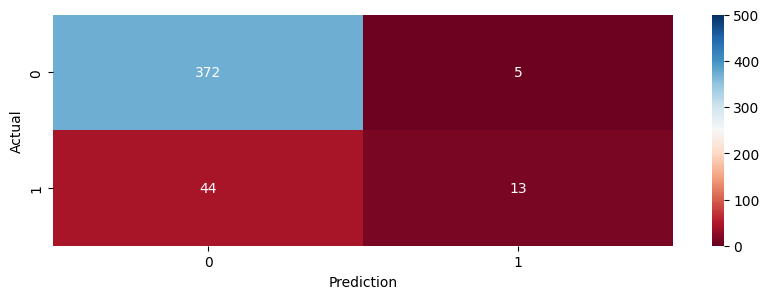

In [56]:
thres = 0.5
title = 'LR' 
model_desc = 'LR test'
confusion_matrix_df, df_metric = metric_for_test_df(thres,title,y_test,prediction_proba_test_lr, model_desc, df_metric)
conf_matrix_viz(confusion_matrix_df)

thre=0.5 TRAIN LR
Classification report: 
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      2201
         1.0       0.64      0.31      0.42       375

    accuracy                           0.87      2576
   macro avg       0.77      0.64      0.68      2576
weighted avg       0.86      0.87      0.86      2576



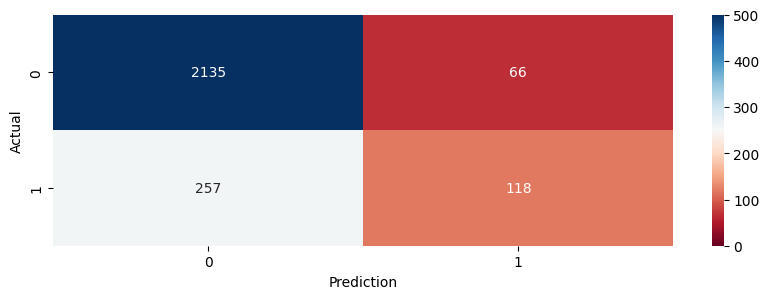

In [57]:
# train
confusion_matrix_df = metric_for_train_df(thres,title,y_train,prediction_proba_train_lr)
conf_matrix_viz(confusion_matrix_df)

thre=0.5 TEST RF
Classification report: 
               precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       377
         1.0       0.56      0.18      0.27        57

    accuracy                           0.87       434
   macro avg       0.72      0.58      0.60       434
weighted avg       0.84      0.87      0.84       434



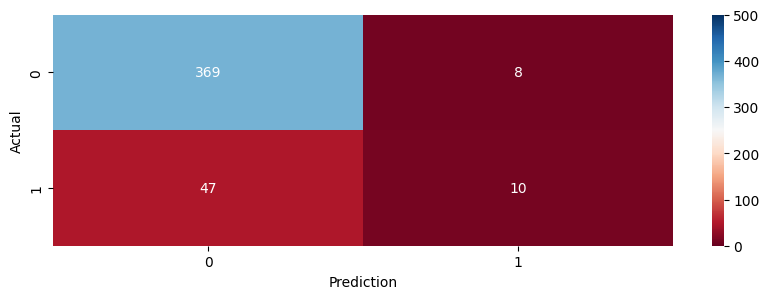

In [58]:
thres = 0.5
title = 'RF' 
model_desc = 'RF test'
confusion_matrix_df, df_metric = metric_for_test_df(thres,title,y_test,prediction_proba_test, model_desc, df_metric)
conf_matrix_viz(confusion_matrix_df)

thre=0.5 TRAIN RF
Classification report: 
               precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2201
         1.0       0.68      0.36      0.47       375

    accuracy                           0.88      2576
   macro avg       0.79      0.67      0.70      2576
weighted avg       0.87      0.88      0.87      2576



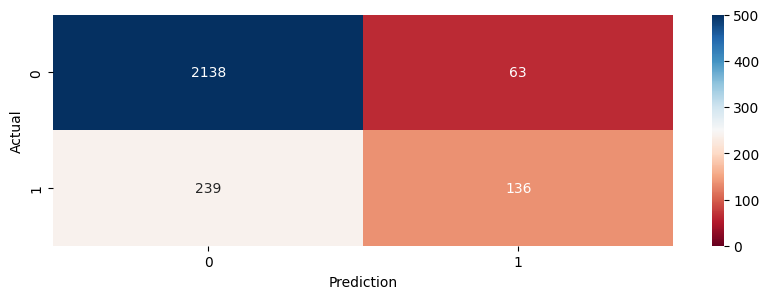

In [59]:
# train
confusion_matrix_df = metric_for_train_df(thres,title,y_train,prediction_proba_train)
conf_matrix_viz(confusion_matrix_df)

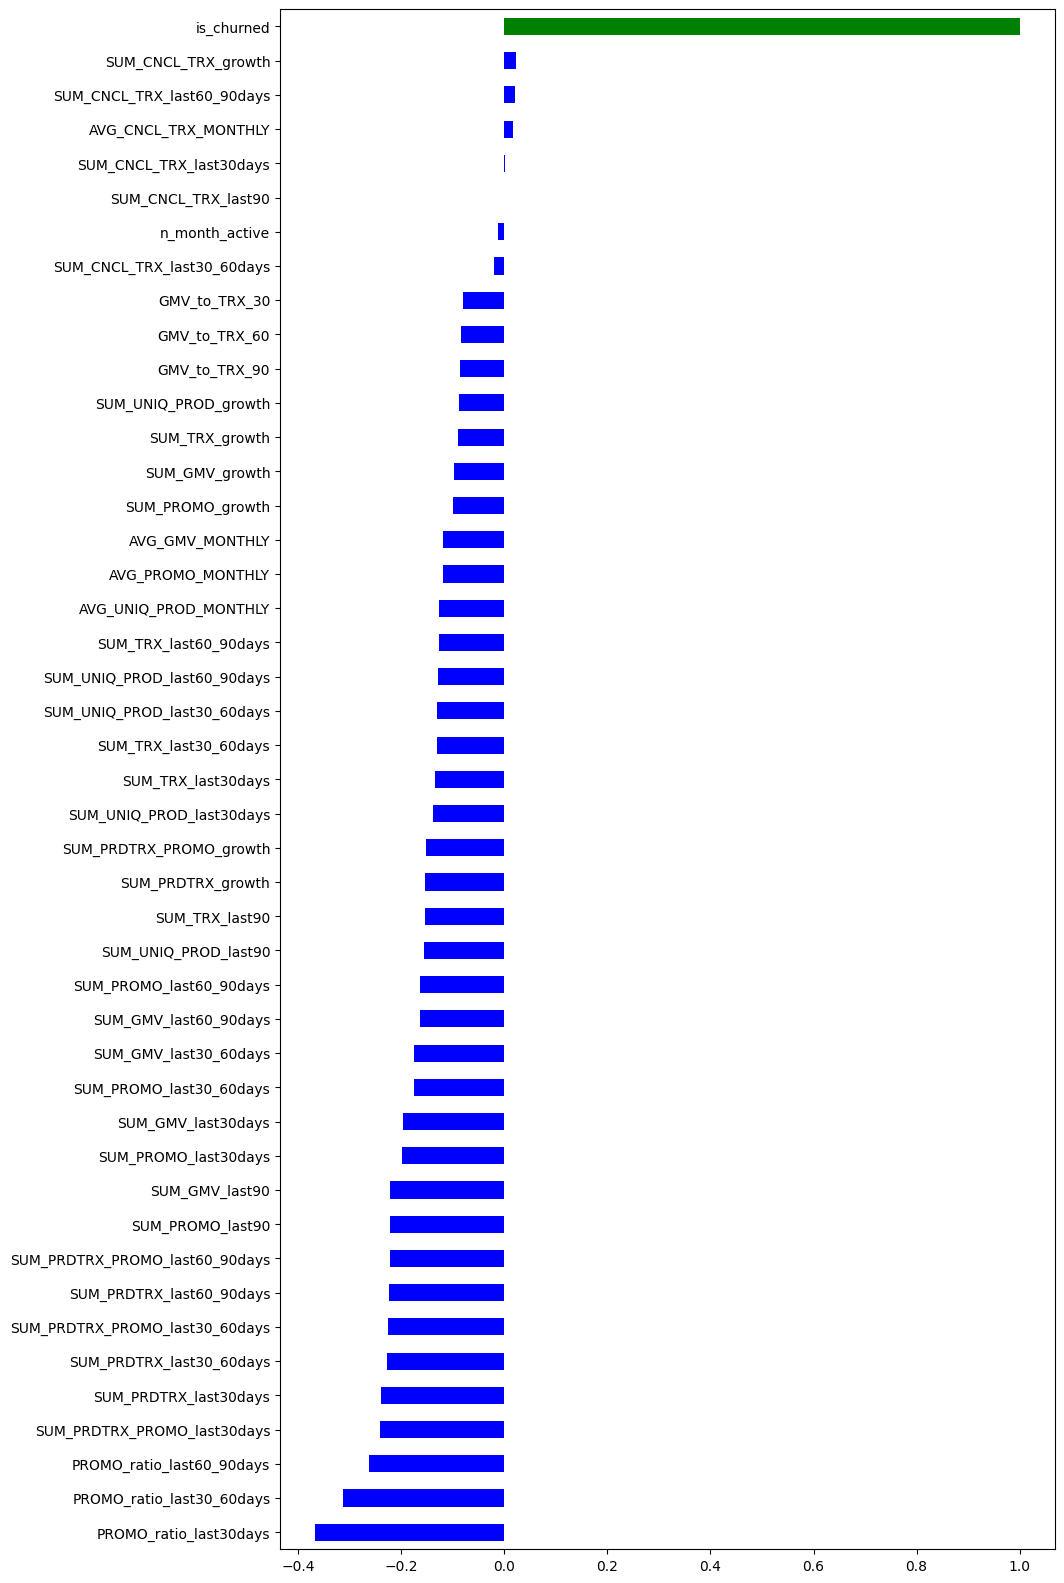

In [60]:
corr_ = correlation_plot(df, col_numerical, col_target)

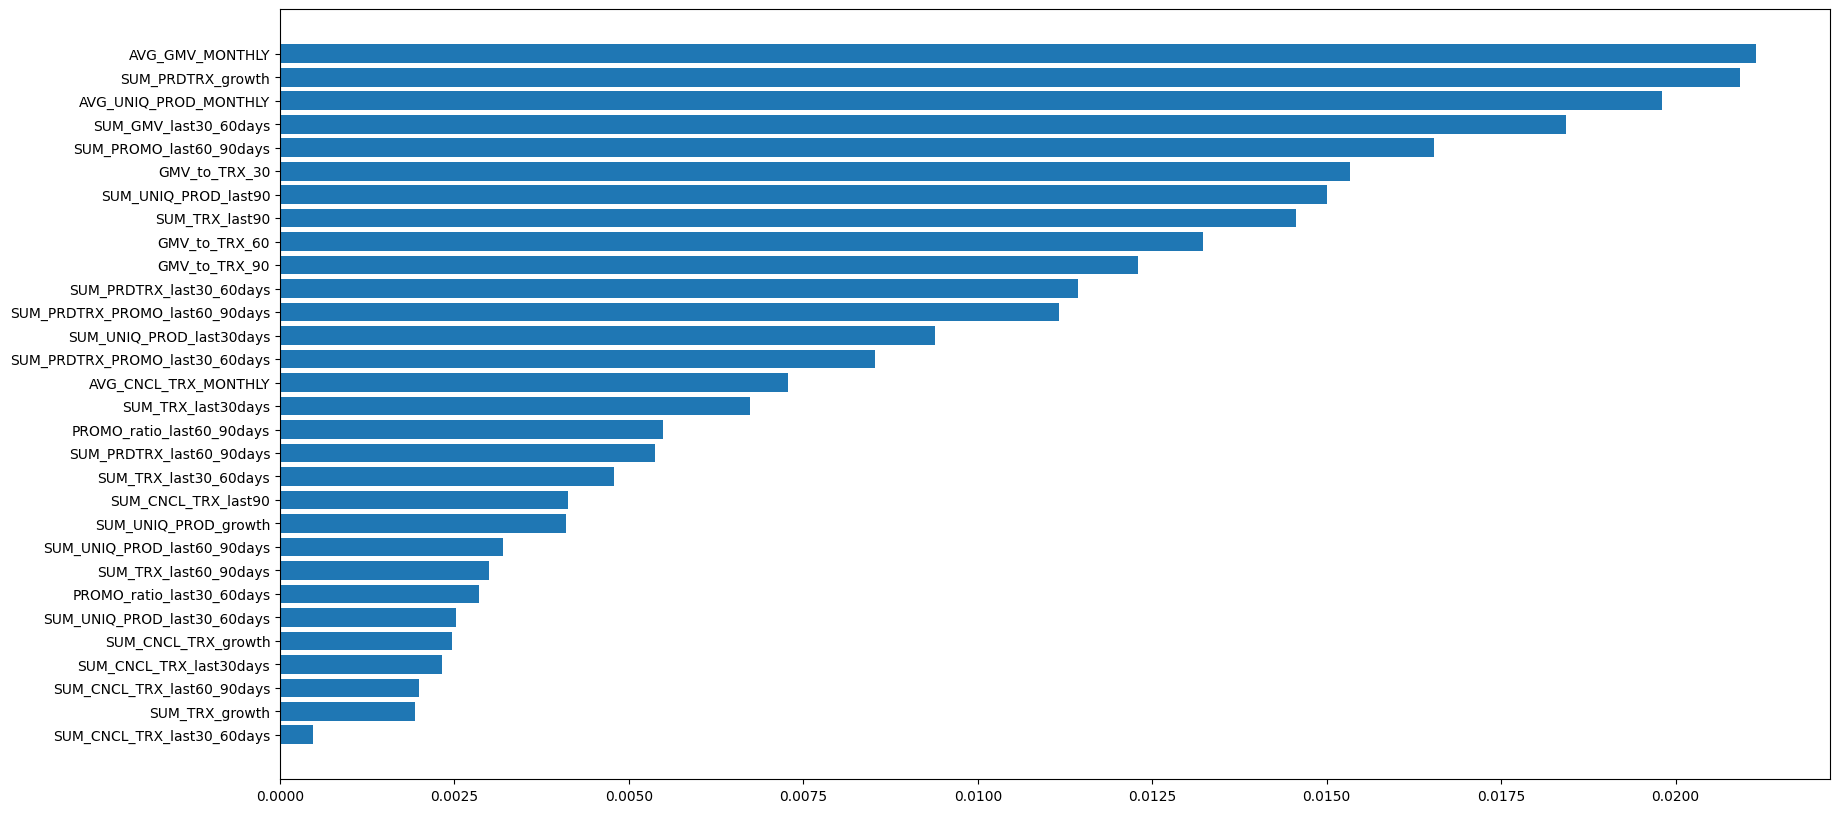

In [61]:
feature_import = feature_importance_plot(col_numerical, clf)

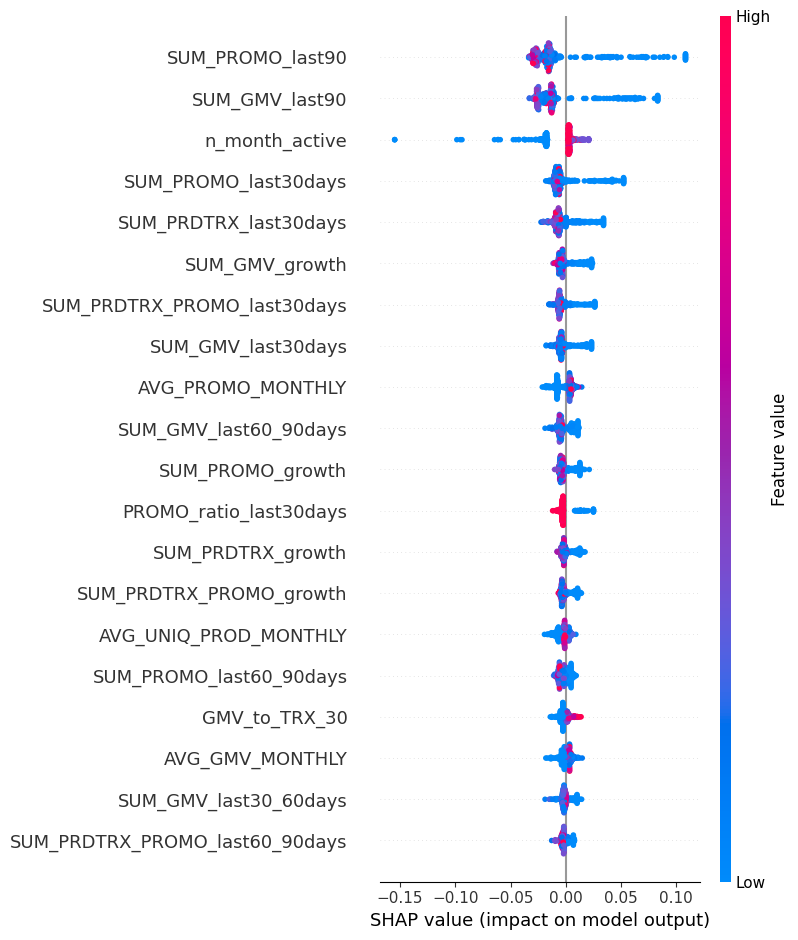

In [62]:
shap_viz(clf, X_test, col_numerical)

In [63]:
[i for i in feature_import.sort_values('value',ascending=False)['col'].head(15)]

['SUM_PROMO_last90',
 'SUM_GMV_last90',
 'SUM_PROMO_last30days',
 'n_month_active',
 'SUM_PRDTRX_last30days',
 'SUM_PRDTRX_PROMO_last30days',
 'SUM_GMV_last30days',
 'SUM_GMV_growth',
 'PROMO_ratio_last30days',
 'SUM_PROMO_growth',
 'SUM_GMV_last60_90days',
 'SUM_PROMO_last30_60days',
 'SUM_PRDTRX_PROMO_growth',
 'AVG_PROMO_MONTHLY',
 'AVG_GMV_MONTHLY']

In [65]:
# to get optimal performance, retrain only using 10 features based on feature importance
col_to_be_trained = ['SUM_PROMO_last90',
 'SUM_GMV_last90',
 'SUM_PROMO_last30days',
 'n_month_active',
 'SUM_PRDTRX_last30days',
 'SUM_PRDTRX_PROMO_last30days',
 'SUM_GMV_last30days',
 'SUM_GMV_growth',
 'PROMO_ratio_last30days',
 'SUM_PROMO_growth',
                    ]

In [66]:
# Model
clf2 = RandomForestClassifier(n_estimators=100,
                            random_state=0,max_depth=5)
clf2.fit(X_train[col_to_be_trained], y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [67]:
prediction_proba_test_x2 = clf2.predict_proba(X_test[col_to_be_trained])
prediction_proba_train_x2 = clf2.predict_proba(X_train[col_to_be_trained])

thre=0.5 TEST RF with 10 features
Classification report: 
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       377
         1.0       0.55      0.21      0.30        57

    accuracy                           0.87       434
   macro avg       0.72      0.59      0.62       434
weighted avg       0.85      0.87      0.85       434



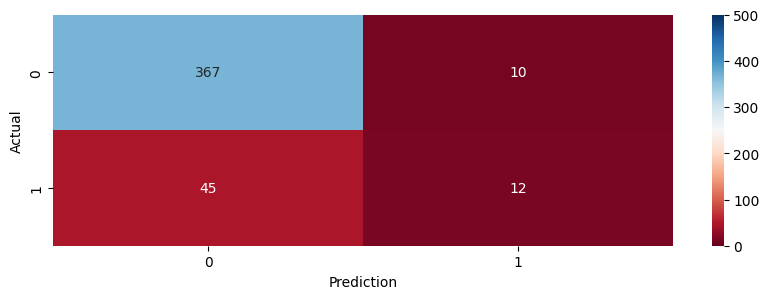

In [68]:
thres = 0.5
title = 'RF with 10 features' 
model_desc = 'RF with 10 features test'
confusion_matrix_df, df_metric = metric_for_test_df(thres,title,y_test,prediction_proba_test_x2, model_desc, df_metric)
conf_matrix_viz(confusion_matrix_df)

thre=0.5 TRAIN RF with 10 features
Classification report: 
               precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2201
         1.0       0.69      0.38      0.49       375

    accuracy                           0.88      2576
   macro avg       0.79      0.68      0.71      2576
weighted avg       0.87      0.88      0.87      2576



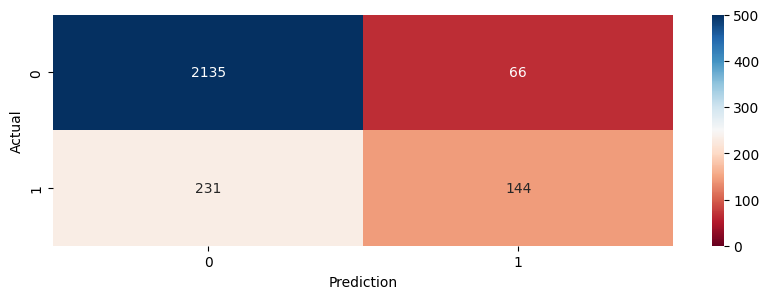

In [69]:
# train
confusion_matrix_df = metric_for_train_df(thres,title,y_train,prediction_proba_train_x2)
conf_matrix_viz(confusion_matrix_df)

In [70]:
# Another attempt, refinement using grid search
params = { 
    'n_estimators': [100,200, 500],
    'max_depth' : [3,5,8],
    'criterion' :['gini', 'entropy']
}
model=RandomForestClassifier(random_state=8)
gridsearch = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring=['f1','recall','precision'],refit='f1')

In [71]:
gridsearch.fit(X_train[col_to_be_trained],y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=8), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8],
                         'n_estimators': [100, 200, 500]},
             refit='f1', scoring=['f1', 'recall', 'precision'])

In [72]:
print('best_params:',gridsearch.best_params_,'f1_score:',gridsearch.best_score_)

best_params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100} f1_score: 0.19363073560727267


In [73]:
gridsearch.cv_results_

{'mean_fit_time': array([ 1.00687242,  3.23293667,  8.94460721,  3.11055698,  4.80249295,
        10.82907434,  3.42778153,  6.26293249, 13.13950524,  2.18728013,
         4.150316  ,  8.45846491,  2.63711762,  5.57879181, 11.69727025,
         3.36681619,  7.36101766, 13.13189964]),
 'std_fit_time': array([0.04575992, 1.09362211, 0.95610426, 0.39747117, 0.83466914,
        1.45559781, 0.53120956, 1.14016639, 2.964928  , 0.16291989,
        0.69618423, 0.59999462, 0.59745147, 1.04235661, 1.47682021,
        0.68461921, 1.31333517, 0.93133697]),
 'mean_score_time': array([0.06966496, 0.22197156, 0.29543033, 0.13969579, 0.13609867,
        0.26020765, 0.09475145, 0.14457765, 0.2264338 , 0.15112424,
        0.14509892, 0.26432004, 0.10279145, 0.15201621, 0.24815483,
        0.10364394, 0.16144013, 0.2202457 ]),
 'std_score_time': array([0.02043235, 0.11859082, 0.07717654, 0.03555388, 0.02046589,
        0.06001637, 0.02059851, 0.02569858, 0.01604536, 0.05544591,
        0.01794201, 0.0606

In [74]:
model_final=gridsearch.best_estimator_

In [75]:
prediction_proba_test_rf_cv=model_final.predict_proba(X_test[col_to_be_trained])

In [76]:
prediction_proba_train_rf_cv=model_final.predict_proba(X_train[col_to_be_trained])

thre=0.5 TEST RF CV with 10 features
Classification report: 
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       377
         1.0       0.55      0.21      0.30        57

    accuracy                           0.87       434
   macro avg       0.72      0.59      0.62       434
weighted avg       0.85      0.87      0.85       434



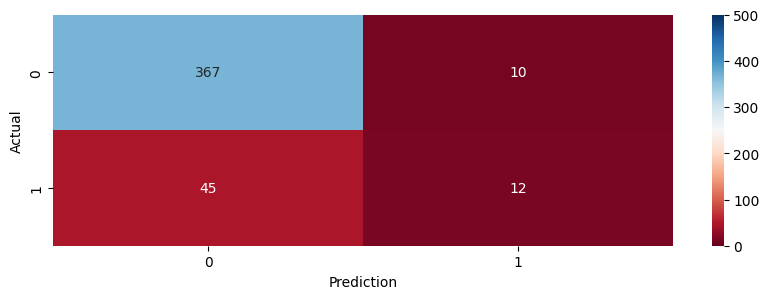

In [77]:
thres = 0.5
title = 'RF CV with 10 features' 
model_desc = 'RF CV with 10 features test'
confusion_matrix_df, df_metric = metric_for_test_df(thres,title,y_test,prediction_proba_test_rf_cv, model_desc, df_metric)
conf_matrix_viz(confusion_matrix_df)

thre=0.5 TRAIN RF CV with 10 features
Classification report: 
               precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2201
         1.0       0.67      0.38      0.48       375

    accuracy                           0.88      2576
   macro avg       0.79      0.67      0.71      2576
weighted avg       0.87      0.88      0.87      2576



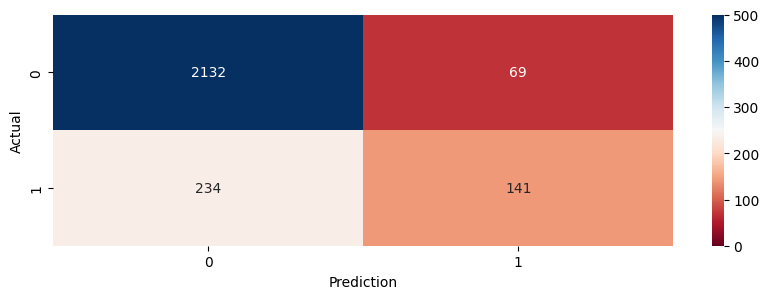

In [78]:
# train
confusion_matrix_df = metric_for_train_df(thres,title,y_train,prediction_proba_train_rf_cv)
conf_matrix_viz(confusion_matrix_df)

In [79]:
df_metric

,model,precision,recall,f1-score,support
0,LR test,0.722222,0.228070,0.346667,57.0
1,RF test,0.555556,0.175439,0.266667,57.0
2,RF with 10 features test,0.545455,0.210526,0.303797,57.0
3,RF CV with 10 features test,0.545455,0.210526,0.303797,57.0


#### decided to pick the last model (RF CV) as not much difference in comparison of test metric values of other RF models but able to reduce gap between train and test performance (overfitting).  I chose not to proceed with Logistic Regression (LR) primarily because it requires addressing multicollinearity and meeting LR assumptions. Since this is essentially just a portfolio project, I decided to refrain from further exploration into LR and conclude my decision here. haha

In [176]:
import joblib
with open('model_churn.joblib','wb') as files:
    joblib.dump(model_final,files)

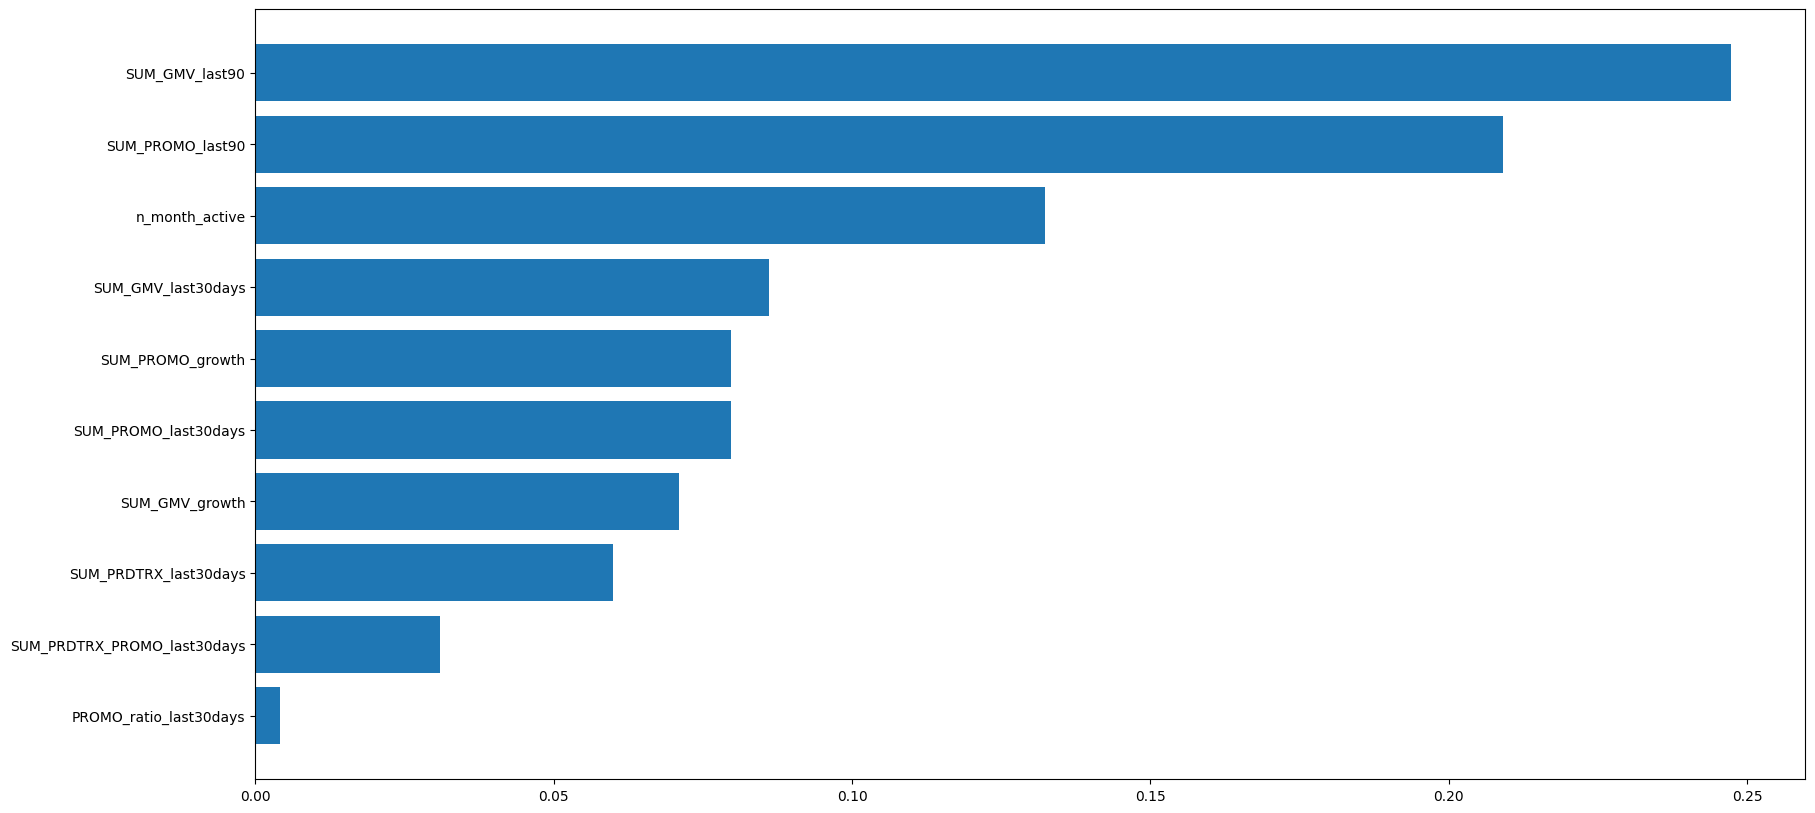

In [82]:
feature_import = feature_importance_plot(col_to_be_trained, model_final)

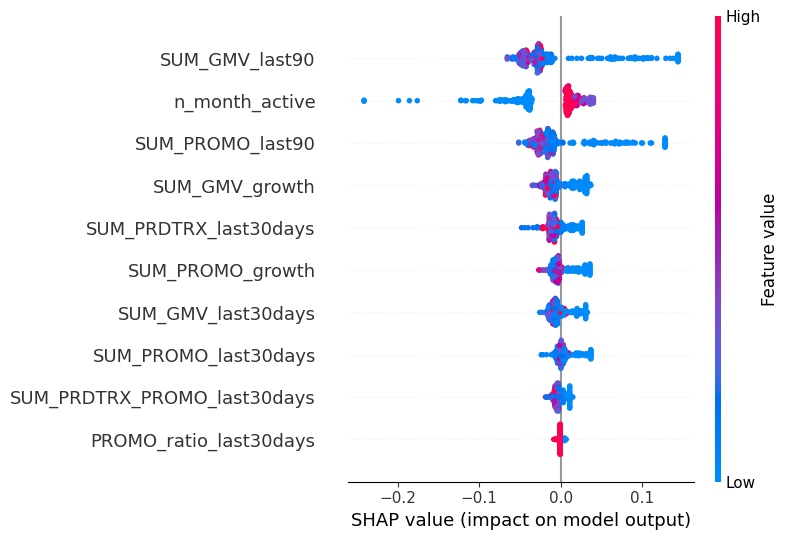

In [83]:
shap_viz(model_final, X_test, col_to_be_trained)

In [84]:
#### check model performance on data from different time frame

In [85]:
X_test_11 = df.loc[df['date'] >=  pd.to_datetime('2022-11-01') ].drop(col_target,axis=1)
y_test_11 = df.loc[df['date'] >=  pd.to_datetime('2022-11-01')][col_target]

In [86]:
X_test_11['p_churn']=model_final.predict_proba(X_test_11[col_to_be_trained])[:,1]

In [87]:
X_test_11['type']='TEST2'

In [89]:
df_combined_train=X_train[col_to_be_trained+['type','customer_id','week_date', 'date']]

In [90]:
df_combined_train[col_target] = y_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
df_combined_train["proba"] = prediction_proba_train_rf_cv[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [92]:
df_combined_test=X_test[col_to_be_trained+['type','customer_id','week_date', 'date']]

In [93]:
df_combined_test[col_target] = y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [94]:
df_combined_test["proba"] = prediction_proba_test_rf_cv[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
df_combined_train.shape

(2576, 16)

In [96]:
df_combined_test.shape

(434, 16)

In [98]:
df_combined_test2=X_test_11[col_to_be_trained+['type','customer_id','week_date', 'date']]

In [99]:
df_combined_test2[col_target] = y_test_11


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [100]:
df_combined_test2.shape

(457, 15)

In [101]:
df_combined_test2["proba"] = X_test_11['p_churn']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [102]:
df_combined = pd.concat([df_combined_train, df_combined_test, df_combined_test2], axis=0)


In [103]:
df_combined

,SUM_PROMO_last90,SUM_GMV_last90,SUM_PROMO_last30days,n_month_active,SUM_PRDTRX_last30days,SUM_PRDTRX_PROMO_last30days,SUM_GMV_last30days,SUM_GMV_growth,PROMO_ratio_last30days,SUM_PROMO_growth,type,customer_id,week_date,date,is_churned,proba
3,103473.686447,574853.813553,35853.177967,0,20,20,199184.322033,0.636447,0.18,0.636447,TRAIN,57,2022-09-12,2022-09-15,0,0.017321
19,55596.279658,308868.220342,29123.313558,0,19,19,161796.186442,1.337955,0.18,1.337955,TRAIN,415,2022-09-26,2022-09-28,0,0.020424
20,94010.033904,522277.966096,28839.355933,0,14,14,160218.644067,0.834214,0.18,0.834214,TRAIN,57,2022-05-23,2022-05-25,0,0.020117
25,47716.779663,265093.220337,9887.796611,0,12,12,54932.203389,0.343017,0.18,0.343017,TRAIN,411,2022-09-19,2022-09-20,0,0.016313
29,33741.533898,187452.966102,10749.661017,0,11,11,59720.338983,0.676637,0.18,0.676637,TRAIN,143,2022-09-12,2022-09-14,0,0.024143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,71989.840676,399943.559324,28866.966101,0,8,8,160372.033899,1.135041,0.18,1.135041,TEST2,375,2022-11-21,2022-11-25,0,0.021973
3409,33135.254232,184084.745768,2837.288135,0,3,3,15762.711865,0.178984,0.18,0.178984,TEST2,197,2022-11-14,2022-11-17,0,0.046109
3418,108309.682377,601720.457623,31516.877291,3,17,17,175093.762709,0.883397,0.18,0.883397,TEST2,57,2022-11-07,2022-11-12,0,0.022121
3420,74053.433896,411407.966104,30930.559321,3,10,10,171836.440679,1.216181,0.18,1.216181,TEST2,375,2022-11-21,2022-11-26,0,0.033799


In [104]:
table_name='churn_pred' # store train test data
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)

client = bigquery.Client(credentials=credentials, project=project_id_bq)
job = client.load_table_from_dataframe(
    df_combined
                
                 , churn_bq_db+'.'+table_name, job_config=job_config
)
job.result()  # Wait for the job to complete.

LoadJob<project=testdv, location=asia-southeast2, id=0a61eccc-68e0-42ca-9e3d-b3168af15bb1>

In [190]:
table_name='churn_pred_score' # table dedicated for storing prediction generated by pipeline
df_score_monitoring = df_combined.loc[df_combined['week_date'] ==  pd.to_datetime('2022-09-19')][['proba','date','customer_id','week_date']+col_to_be_trained]
df_score_monitoring['date'] = pd.to_datetime(df_score_monitoring['date'])
# df_score_monitoring.rename(columns={'week_date':'created_at'},inplace=True)
df_score_monitoring['created_at']=df_score_monitoring["week_date"]
# df_score_monitoring["week_date"]=pd.to_datetime(df_score_monitoring["week_date"]).dt.strftime("%Y-%m-%d")
df_score_monitoring['created_at']=pd.to_datetime(df_score_monitoring['created_at'])# assume it only run weekly every monday,
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_APPEND",
    schema=[
                    bigquery.SchemaField("date", "DATETIME"),
                    bigquery.SchemaField("week_date", "DATE"),
                    bigquery.SchemaField("created_at", "DATETIME"),
                ],
    # time_partitioning=bigquery.TimePartitioning(
    #                 type_=bigquery.TimePartitioningType.DAY,
    #                 field="week_date",  # field to use for partitioning
    #             ),
    
)

client = bigquery.Client(credentials=credentials, project=project_id_bq)
job = client.load_table_from_dataframe(
    df_score_monitoring
                
                 , churn_bq_db+'.'+table_name, job_config=job_config
)
job.result()  # Wait for the job to complete.

LoadJob<project=testdv, location=asia-southeast2, id=1ed27840-475b-4d8a-b1bb-29843c186165>

In [189]:
table_name='churn_pred_score' # table dedicated for storing prediction generated by pipeline
df_score_monitoring = df_combined.loc[df_combined['date'] >=  pd.to_datetime('2022-11-01')][['proba','date','customer_id','week_date']+col_to_be_trained]
df_score_monitoring['date'] = pd.to_datetime(df_score_monitoring['date'])
# df_score_monitoring.rename(columns={'week_date':'created_at'},inplace=True)
df_score_monitoring['created_at']=df_score_monitoring["week_date"]
# df_score_monitoring["week_date"]=pd.to_datetime(df_score_monitoring["week_date"]).dt.strftime("%Y-%m-%d")
df_score_monitoring['created_at']=pd.to_datetime(df_score_monitoring['created_at'])# assume it only run weekly every monday,
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
    schema=[
                    bigquery.SchemaField("date", "DATETIME"),
                    bigquery.SchemaField("week_date", "DATE"),
                    bigquery.SchemaField("created_at", "DATETIME"),
                ],
    # time_partitioning=bigquery.TimePartitioning(
    #                 type_=bigquery.TimePartitioningType.DAY,
    #                 field="week_date",  # field to use for partitioning
    #             ),
    
)

client = bigquery.Client(credentials=credentials, project=project_id_bq)
job = client.load_table_from_dataframe(
    df_score_monitoring
                
                 , churn_bq_db+'.'+table_name, job_config=job_config
)
job.result()  # Wait for the job to complete.

LoadJob<project=testdv, location=asia-southeast2, id=99c07dd1-c1ef-4b2b-b18b-2e0caa4bf8dc>

In [106]:
df_metric_final=pd.DataFrame(columns=['dataset','metric_type','value'])

In [107]:
def metric_time_evolution(thres,df,col_actual,col_pred, df_metric, week_column_name):
    """
    display metrics and document them in a table
    input:
        threshold of the proba_score
        df
        y actual column name
        y pred column name
        week column name
        df_metric
    output:
        df_metric
    """
    for i in df[week_column_name].unique():
        y_act = df.loc[df[week_column_name]==i,col_actual].tolist()
        y_pred_temp = df.loc[df[week_column_name]==i,col_pred]
        y_pred = np.where(y_pred_temp>thres,1,0)
        df_metric = df_metric._append({'dataset': i,'metric_type':'f1_score','value': f1_score(y_act,y_pred)},ignore_index=True)
        df_metric = df_metric._append({'dataset': i,'metric_type':'recall','value': recall_score(y_act,y_pred)},ignore_index=True)
        df_metric = df_metric._append({'dataset': i,'metric_type':'precision','value': precision_score(y_act,y_pred)},ignore_index=True)
    return df_metric

In [108]:
df_combined

,SUM_PROMO_last90,SUM_GMV_last90,SUM_PROMO_last30days,n_month_active,SUM_PRDTRX_last30days,SUM_PRDTRX_PROMO_last30days,SUM_GMV_last30days,SUM_GMV_growth,PROMO_ratio_last30days,SUM_PROMO_growth,type,customer_id,week_date,date,is_churned,proba
3,103473.686447,574853.813553,35853.177967,0,20,20,199184.322033,0.636447,0.18,0.636447,TRAIN,57,2022-09-12,2022-09-15,0,0.017321
19,55596.279658,308868.220342,29123.313558,0,19,19,161796.186442,1.337955,0.18,1.337955,TRAIN,415,2022-09-26,2022-09-28,0,0.020424
20,94010.033904,522277.966096,28839.355933,0,14,14,160218.644067,0.834214,0.18,0.834214,TRAIN,57,2022-05-23,2022-05-25,0,0.020117
25,47716.779663,265093.220337,9887.796611,0,12,12,54932.203389,0.343017,0.18,0.343017,TRAIN,411,2022-09-19,2022-09-20,0,0.016313
29,33741.533898,187452.966102,10749.661017,0,11,11,59720.338983,0.676637,0.18,0.676637,TRAIN,143,2022-09-12,2022-09-14,0,0.024143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,71989.840676,399943.559324,28866.966101,0,8,8,160372.033899,1.135041,0.18,1.135041,TEST2,375,2022-11-21,2022-11-25,0,0.021973
3409,33135.254232,184084.745768,2837.288135,0,3,3,15762.711865,0.178984,0.18,0.178984,TEST2,197,2022-11-14,2022-11-17,0,0.046109
3418,108309.682377,601720.457623,31516.877291,3,17,17,175093.762709,0.883397,0.18,0.883397,TEST2,57,2022-11-07,2022-11-12,0,0.022121
3420,74053.433896,411407.966104,30930.559321,3,10,10,171836.440679,1.216181,0.18,1.216181,TEST2,375,2022-11-21,2022-11-26,0,0.033799


In [109]:
df_metric_final = metric_time_evolution(thres,df_combined,col_target, "proba", df_metric, "week_date")

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [110]:
table_name='churn_metric_week'
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)

client = bigquery.Client(credentials=credentials, project=project_id_bq)
job = client.load_table_from_dataframe(
    df_metric_final
                
                 , churn_bq_db+'.'+table_name, job_config=job_config
)
job.result()  # Wait for the job to complete.

LoadJob<project=testdv, location=asia-southeast2, id=4ec1c112-f224-4f0e-bc64-c4de358c2e3c>

In [162]:
# from sklearn.tree import export_graphviz
# from IPython import display

In [166]:
# !pip install graphviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------------------------- ------------- 30.7/47.1 kB 435.7 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 472.9 kB/s eta 0:00:00


In [172]:
# !conda install python-graphviz

In [173]:
# import graphviz

In [175]:
# estimator = model_final.estimators_[1]
# # Export as dot file
# dot_data = export_graphviz(estimator, out_file=None, 
#                 feature_names = col_to_be_trained,
#                 class_names = df_combined_train[col_target].apply(lambda x: 'churn'if x==1 else 'not churn'),
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# graph = graphviz.Source(dot_data)
# graph.format = "png"
# graph.render("tree.png")

In [111]:
from sklearn import metrics
def calculate_gini(condition, project_id_bq, churn_bq_db, table_name, credentials):
    query = """
    SELECT
        proba,is_churned
    FROM {table}
    WHERE {condition}
    """.format(
        table = project_id_bq+'.'+churn_bq_db+'.'+table_name, condition=condition
    )

    df_roe = read_bq(
    query, credentials, project_id, None)
    fpr, tpr, thresholds = metrics.roc_curve(df_roe["is_churned"],df_roe["proba"], pos_label=1)
    return 2*metrics.auc(fpr, tpr)-1

In [112]:
df_gini=pd.DataFrame(columns=["week","GINI"])

In [113]:
from sklearn.metrics import roc_curve
week_column_name = 'week_date'
for i in df[week_column_name].unique():
    
    df_filter = df_combined.loc[df_combined[week_column_name]==i]
    fpr, tpr, thresholds = roc_curve(df_filter["is_churned"].tolist(),df_filter["proba"].tolist(), pos_label=1)
    gini_ = 2*metrics.auc(fpr, tpr)-1
    df_gini=df_gini._append({"week":i,"GINI":gini_},ignore_index=True)

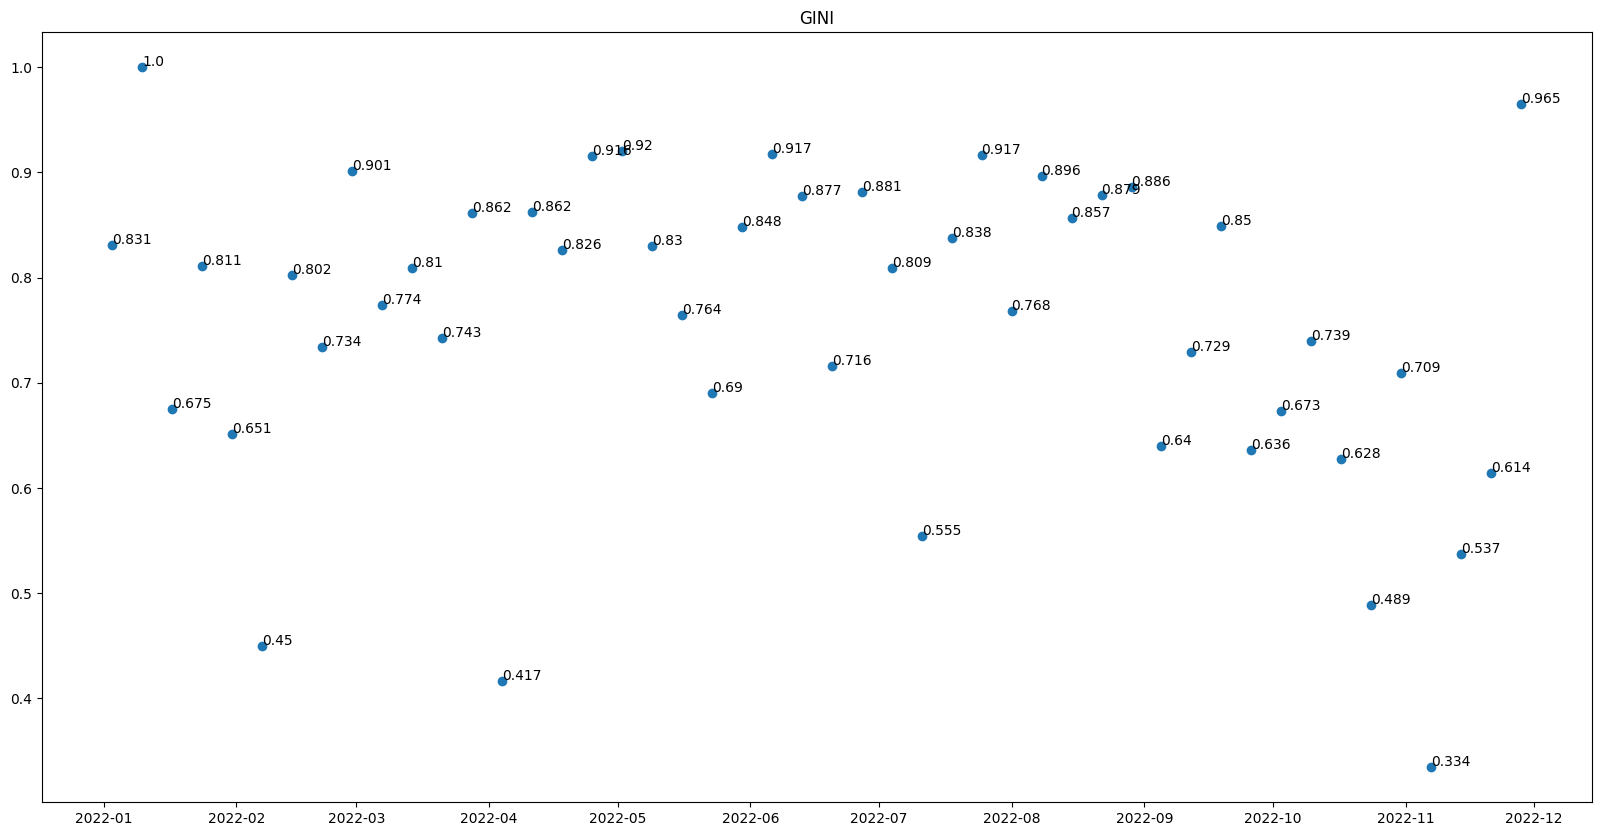

In [114]:
plt.figure(figsize=(20,10))
plt.scatter(df_gini["week"],df_gini["GINI"])
plt.title("GINI")
for i in range(df_gini.shape[0]):
    plt.text(x=df_gini["week"][i],y=df_gini["GINI"][i]+0.001,s=round(df_gini["GINI"][i],3))
plt.savefig('gini.png')
plt.show()

In [115]:
table_name='churn_gini_week'
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)

client = bigquery.Client(credentials=credentials, project=project_id_bq)
job = client.load_table_from_dataframe(
    df_gini
                
                 , churn_bq_db+'.'+table_name, job_config=job_config
)
job.result()  # Wait for the job to complete.

LoadJob<project=testdv, location=asia-southeast2, id=c0c26d5b-e6bd-4cae-989b-cf2a3f511f5c>

In [135]:
# finding threshold
y_actual = df_combined.loc[df_combined['type']=='TEST','is_churned'].tolist()
y_prediction = df_combined.loc[df_combined['type']=='TEST','proba'].tolist()

In [169]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds, title):
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.ylim([0,1.1])


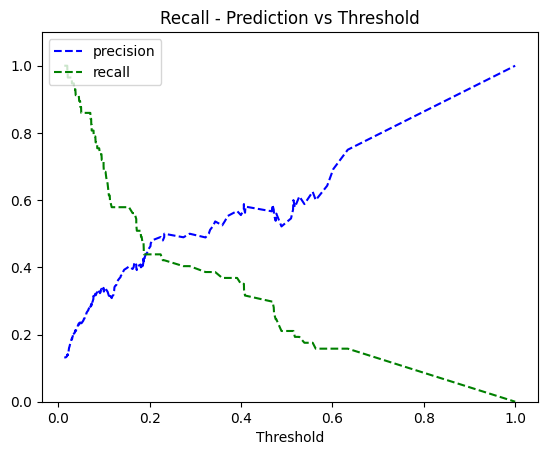

In [170]:
prec, rec, tre = precision_recall_curve(df_combined.loc[df_combined['type']=='TEST','is_churned'],df_combined.loc[df_combined['type']=='TEST','proba'] )

plot_prec_recall_vs_tresh(prec, rec, np.append(tre,1), 'Recall - Prediction vs Threshold')
plt.show()

In [171]:
from sklearn.metrics import roc_curve, precision_recall_curve,recall_score,precision_score
def precision_opt(label,proba,value):
    pr={}
    for i in np.arange(0,1,0.02):
        pr[i]=precision_score(label, proba.apply(lambda x: 1if x>i else 0))
    key_list = list(pr.keys())
    val_list = list(pr.values())
    position = val_list.index(min(val_list, key=lambda x:abs(x-value))) ###CHANGE THE DESIRED PRECISION SCORE 0.9
    # print(pr,key_list[position])
    return pr,key_list[position]

In [172]:
def recall_opt(label,proba,value):
    rc={}
    for i in np.arange(0,1,0.02):
        rc[i]=recall_score(label, proba.apply(lambda x: 1 if x>i else 0))
    key_list = list(rc.keys())
    val_list = list(rc.values())
    position = val_list.index(min(val_list, key=lambda x:abs(x-value))) ###CHANGE THE DESIRED RECALL SCORE 0.9
    # print(rc, key_list[position])
    return rc,key_list[position]


In [173]:
pr,thres_p=precision_opt(df_combined.loc[df_combined['type']=='TEST','is_churned'],df_combined.loc[df_combined['type']=='TEST','proba'],0.8)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

In [174]:
rec,thres_r=recall_opt(df_combined.loc[df_combined['type']=='TEST','is_churned'],df_combined.loc[df_combined['type']=='TEST','proba'],0.5)

In [187]:
print(thres_p,pr)

0.62 {0.0: 0.1313364055299539, 0.02: 0.1407035175879397, 0.04: 0.2175732217573222, 0.06: 0.2578947368421053, 0.08: 0.3191489361702128, 0.1: 0.3305084745762712, 0.12: 0.3173076923076923, 0.14: 0.3793103448275862, 0.16: 0.3950617283950617, 0.18: 0.4, 0.2: 0.46296296296296297, 0.22: 0.49019607843137253, 0.24: 0.48936170212765956, 0.26: 0.48936170212765956, 0.28: 0.5, 0.3: 0.4888888888888889, 0.32: 0.4888888888888889, 0.34: 0.5365853658536586, 0.36: 0.5384615384615384, 0.38: 0.5675675675675675, 0.4: 0.5714285714285714, 0.42: 0.5666666666666667, 0.44: 0.5666666666666667, 0.46: 0.5666666666666667, 0.48: 0.5217391304347826, 0.5: 0.5454545454545454, 0.52: 0.6111111111111112, 0.54: 0.625, 0.56: 0.6, 0.58: 0.6428571428571429, 0.6: 0.6923076923076923, 0.62: 0.75, 0.64: 0.0, 0.66: 0.0, 0.68: 0.0, 0.7000000000000001: 0.0, 0.72: 0.0, 0.74: 0.0, 0.76: 0.0, 0.78: 0.0, 0.8: 0.0, 0.8200000000000001: 0.0, 0.84: 0.0, 0.86: 0.0, 0.88: 0.0, 0.9: 0.0, 0.92: 0.0, 0.9400000000000001: 0.0, 0.96: 0.0, 0.98: 0.0}

In [186]:
print(thres_r,rec)

0.18 {0.0: 1.0, 0.02: 0.9824561403508771, 0.04: 0.9122807017543859, 0.06: 0.8596491228070176, 0.08: 0.7894736842105263, 0.1: 0.6842105263157895, 0.12: 0.5789473684210527, 0.14: 0.5789473684210527, 0.16: 0.5614035087719298, 0.18: 0.49122807017543857, 0.2: 0.43859649122807015, 0.22: 0.43859649122807015, 0.24: 0.40350877192982454, 0.26: 0.40350877192982454, 0.28: 0.40350877192982454, 0.3: 0.38596491228070173, 0.32: 0.38596491228070173, 0.34: 0.38596491228070173, 0.36: 0.3684210526315789, 0.38: 0.3684210526315789, 0.4: 0.3508771929824561, 0.42: 0.2982456140350877, 0.44: 0.2982456140350877, 0.46: 0.2982456140350877, 0.48: 0.21052631578947367, 0.5: 0.21052631578947367, 0.52: 0.19298245614035087, 0.54: 0.17543859649122806, 0.56: 0.15789473684210525, 0.58: 0.15789473684210525, 0.6: 0.15789473684210525, 0.62: 0.15789473684210525, 0.64: 0.0, 0.66: 0.0, 0.68: 0.0, 0.7000000000000001: 0.0, 0.72: 0.0, 0.74: 0.0, 0.76: 0.0, 0.78: 0.0, 0.8: 0.0, 0.8200000000000001: 0.0, 0.84: 0.0, 0.86: 0.0, 0.88: 0.